In [ ]:
import xarray as xr 
import lenapy 
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('robin')
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
import seaborn as sns
import dask.bag as db
from tqdm.notebook import tqdm
import pandas as pd
import os

In [2]:
from dask.distributed import Client 
client = Client(n_workers=40)

In [4]:
ds_tos = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/tos_data.nc')
# ds_tos = (ds_tos - ds_tos.isel(time=range(10)).xtime.filter('moving_average', cutoff=3).isel(time=0))

ds_lbd = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/lbd_pi_iceSAF_correct.nc')
# ds_lbd = pd.read_csv('/homedata/rguillaume/data/Radiative_response_dynamics/Application_transient_response_v2/results/lbd_ss_all_models.csv', index_col=0).\
#     iloc[:,1:-1].loc[ds_tos.model].mean(axis=1).to_xarray().rename(index='model').rename('lbd_pi_sst')

ds_dF =  xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/dF.nc')

ds_NT =  xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/N_T.nc')
# ds_NT = (ds_NT - ds_NT.xtime.filter('moving_average', cutoff=3).isel(time=0))

ds = xr.merge([ds_tos, ds_NT, ds_dF,ds_lbd.mean('method')[['lbd_u_icecorr']].rename(lbd_u_icecorr='lbd_u') ])

# Compute Rp with GF

In [5]:
gf_directory = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
list_gf_models = os.listdir(gf_directory)


list_gf_regridded = []
for model in tqdm(list_gf_models):
    with xr.open_dataset(f"{gf_directory}/{model}") as ds_raw:
        if "spatial_feedbacks_from_both" in ds_raw.variables:
            data = ds_raw.spatial_feedbacks_from_both
        else:
            data = ds_raw.spatial_feedbacks_from_warming
    regridded_ds = xe.Regridder(data, ds.tos_control_grid, 'conservative_normed', periodic=True)(data).assign_coords(GF_source=model.split('.')[0])
    list_gf_regridded.append(regridded_ds)
greens_functions = xr.concat(list_gf_regridded, dim='GF_source' )
greens_functions = greens_functions.where(greens_functions!=0)
# greens_functions = greens_functions.where(greens_functions.count('GF_source')==greens_functions.count('GF_source').max())
greens_functions.attrs['units'] = 'W/m²'
greens_functions.attrs['long_name'] = "Green's functions coefficients"

  0%|          | 0/6 [00:00<?, ?it/s]

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [6]:
dRp_gf = (greens_functions*ds.pattern_tos_1pct).weighted(np.cos(np.deg2rad(greens_functions.lat))).mean(['lon','lat'])
dRp_gf = xr.concat([dRp_gf,dRp_gf.mean('GF_source').assign_coords(GF_source='mean')], dim='GF_source')
ds['dRp_gf'] = dRp_gf

# Find f

In [7]:
ds['dRu'] = ds.lbd_u*ds.tas
Y = ds.eei - ds.dRp_gf - ds.dRu
ds['f'] = Y.curvefit('time', lambda t,f : f*t).sel(param='f', drop=True).curvefit_coefficients.drop('degree')
ds['dF'] = ds.f*ds.time 
ds['eei_reco'] = ds.dF + ds.dRp_gf + ds.dRu
ds['dR'] = ds.eei-ds.dF 
ds['dR_reco'] = ds.dRp_gf + ds.dRu


/tmp/ipykernel_326955/4101792572.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds['f'] = Y.curvefit('time', lambda t,f : f*t).sel(param='f', drop=True).curvefit_coefficients.drop('degree')


# Find integration params

In [8]:
params = list(pd.read_csv('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/inputs/geoff_samples_extract.csv', index_col=0)[['cmix','cdeep','gamma_2l']].values)[:10000]


for source in ds.GF_source.values:
# for source in ['mean']: 
    all_fit = []
    all_best_params = []
    for model in tqdm(ds.model):
        F_func =  interp1d(ds.time, ds.dF.sel(GF_source=source).sel(model=model).values)
        Rp_func =  interp1d(ds.time, ds.dRp_gf.sel(GF_source=source).sel(model=model).values)
        lbd_u = ds.sel(model=model).lbd_u.values
        tas = ds.tas.sel(model=model).values[:149]
        def fit(params):
            Cs, Cd, gamma = params
            def derive(t, T):
                Ts, Td = T
                dTs = lbd_u/Cs*Ts + F_func(t)/Cs + Rp_func(t)/Cs - gamma/Cs*(Ts-Td)
                dTd = gamma/Cd*(Ts-Td)
                return [dTs, dTd]
            sol = solve_ivp(derive, [0, 150], [0,0], t_eval=np.arange(150))
            return sol.y

        bag = db.from_sequence(params)
        result = bag.map(fit).compute()
        ds_fit = xr.concat([xr.DataArray(result[k][0][:149], dims=['time'], coords=dict(time=np.arange(149))) for k in range(len(result))], dim='params').assign_coords(params=np.arange(len(params)))
        all_fit.append(ds_fit.assign_coords(model=model))
        best_params = params[((ds_fit-tas)**2).sum('time').to_series().sort_values().index[0]]
    ds_fit = xr.concat(all_fit, dim='model')
    ds_fit.to_netcdf(f'/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/all_integrations_{source}.nc')

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
params = list(pd.read_csv('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/inputs/geoff_samples_extract.csv', index_col=0)[['cmix','cdeep','gamma_2l']].values)
all_source = []
for source in tqdm(list(ds.GF_source.values)):
    ds_fit = xr.open_dataarray(f'/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/all_integrations_{source}.nc')
    best_params = ((ds_fit-ds.tas)**2).mean('time').argmin('params')
    all_fit = []

    for model in ds.model:
        F_func =  interp1d(ds.time, ds.dF.sel(model=model, GF_source=source).values)
        Rp_func =  interp1d(ds.time, ds.dRp_gf.sel(model=model, GF_source=source).values)
        # C = 10
        lbd_u = ds.lbd_u.sel(model=model)
        # tas = ds.tas.sel(model=model).values[:149]
        def fit(params):
            Cs, Cd, gamma = params
            def derive(t, T):
                Ts, Td = T
                dTs = lbd_u/Cs*Ts + F_func(t)/Cs + Rp_func(t)/Cs - gamma/Cs*(Ts-Td)
                dTd = gamma/Cd*(Ts-Td)
                return [dTs, dTd]
            sol = solve_ivp(derive, [0, 150], [0,0], t_eval=np.arange(150))
            return sol.y
        def fit_no_pattern(params):
            Cs, Cd, gamma = params
            def derive(t, T):
                Ts, Td = T
                dTs = lbd_u/Cs*Ts + F_func(t)/Cs - gamma/Cs*(Ts-Td)
                dTd = gamma/Cd*(Ts-Td)
                return [dTs, dTd]
            sol = solve_ivp(derive, [0, 150], [0,0], t_eval=np.arange(150))
            return sol.y
        def fit_pattern(params):
            Cs, Cd, gamma = params
            def derive(t, T):
                Ts, Td = T
                dTs = lbd_u/Cs*Ts + Rp_func(t)/Cs - gamma/Cs*(Ts-Td)
                dTd = gamma/Cd*(Ts-Td)
                return [dTs, dTd]
            sol = solve_ivp(derive, [0, 150], [0,0], t_eval=np.arange(150))
            return sol.y
            
        Cs, Cd, gamma = params[best_params.sel(model=model).values]
        result_full = fit((Cs, Cd, gamma))[:,:149]
        result_no_pattern = fit_no_pattern((Cs, Cd, gamma))[:,:149]
        result_pattern = fit_pattern((Cs, Cd, gamma))[:,:149]
        
        ds_result = xr.DataArray(np.array([result_full, result_no_pattern, result_pattern]), 
                                dims=['integration_type','depth', 'time'], 
                                coords=dict(integration_type=['full','no_pattern','only_pattern'],
                                            time=np.arange(149),
                                            depth=['surface','deep']
                                        )).assign_coords(model=model, Cs=Cs, Cd=Cd, gamma=gamma)
        all_fit.append(ds_result)
    ds_integrated = xr.concat(all_fit, dim='model')
    all_source.append(ds_integrated.assign_coords(GF_source=source))
ds['integrated_tas'] = xr.concat(all_source, dim='GF_source')


  0%|          | 0/7 [00:00<?, ?it/s]

# Save ds

In [11]:
ds.to_netcdf('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/full_preprocessed.nc')

# Check variables 

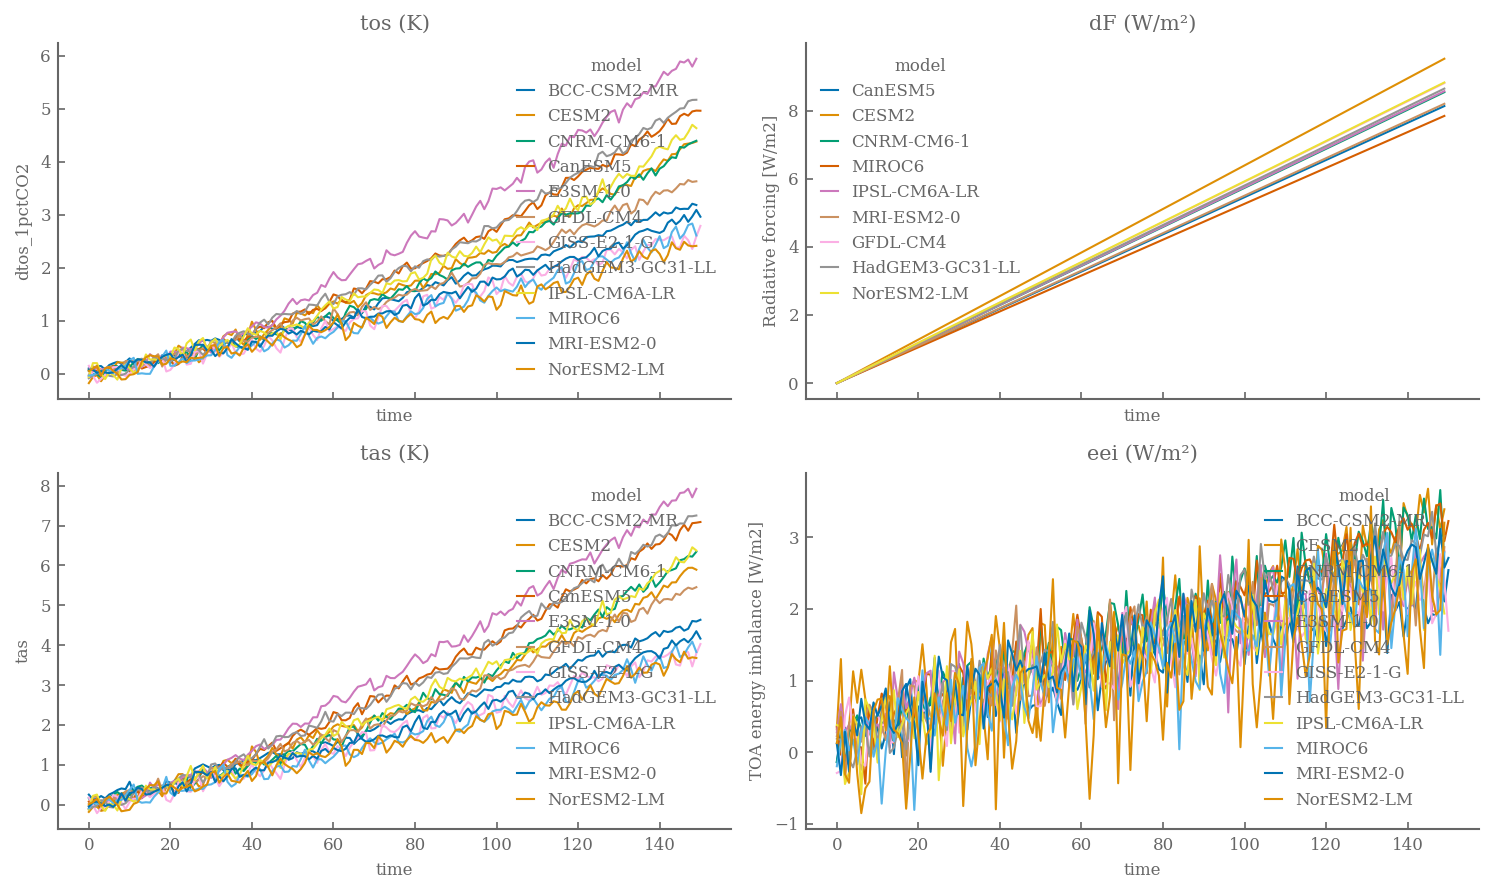

In [10]:
fig, axs = plt.subplots(2,2, figsize = (10,6), sharex='col', )

axs=axs.flatten()
ds_tos.dtos_1pctCO2.plot(hue='model', ax=axs[0])
ds_NT.tas.plot(hue='model', ax=axs[2])
ds_NT.eei.plot(hue='model', ax=axs[3])
ds_dF.dF.plot(hue='model', ax=axs[1])

axs[0].set_title('tos (K)')
axs[1].set_title('dF (W/m²)')
axs[2].set_title('tas (K)')
axs[3].set_title('eei (W/m²)')
plt.tight_layout()

# plt.savefig('check_variables.pdf')

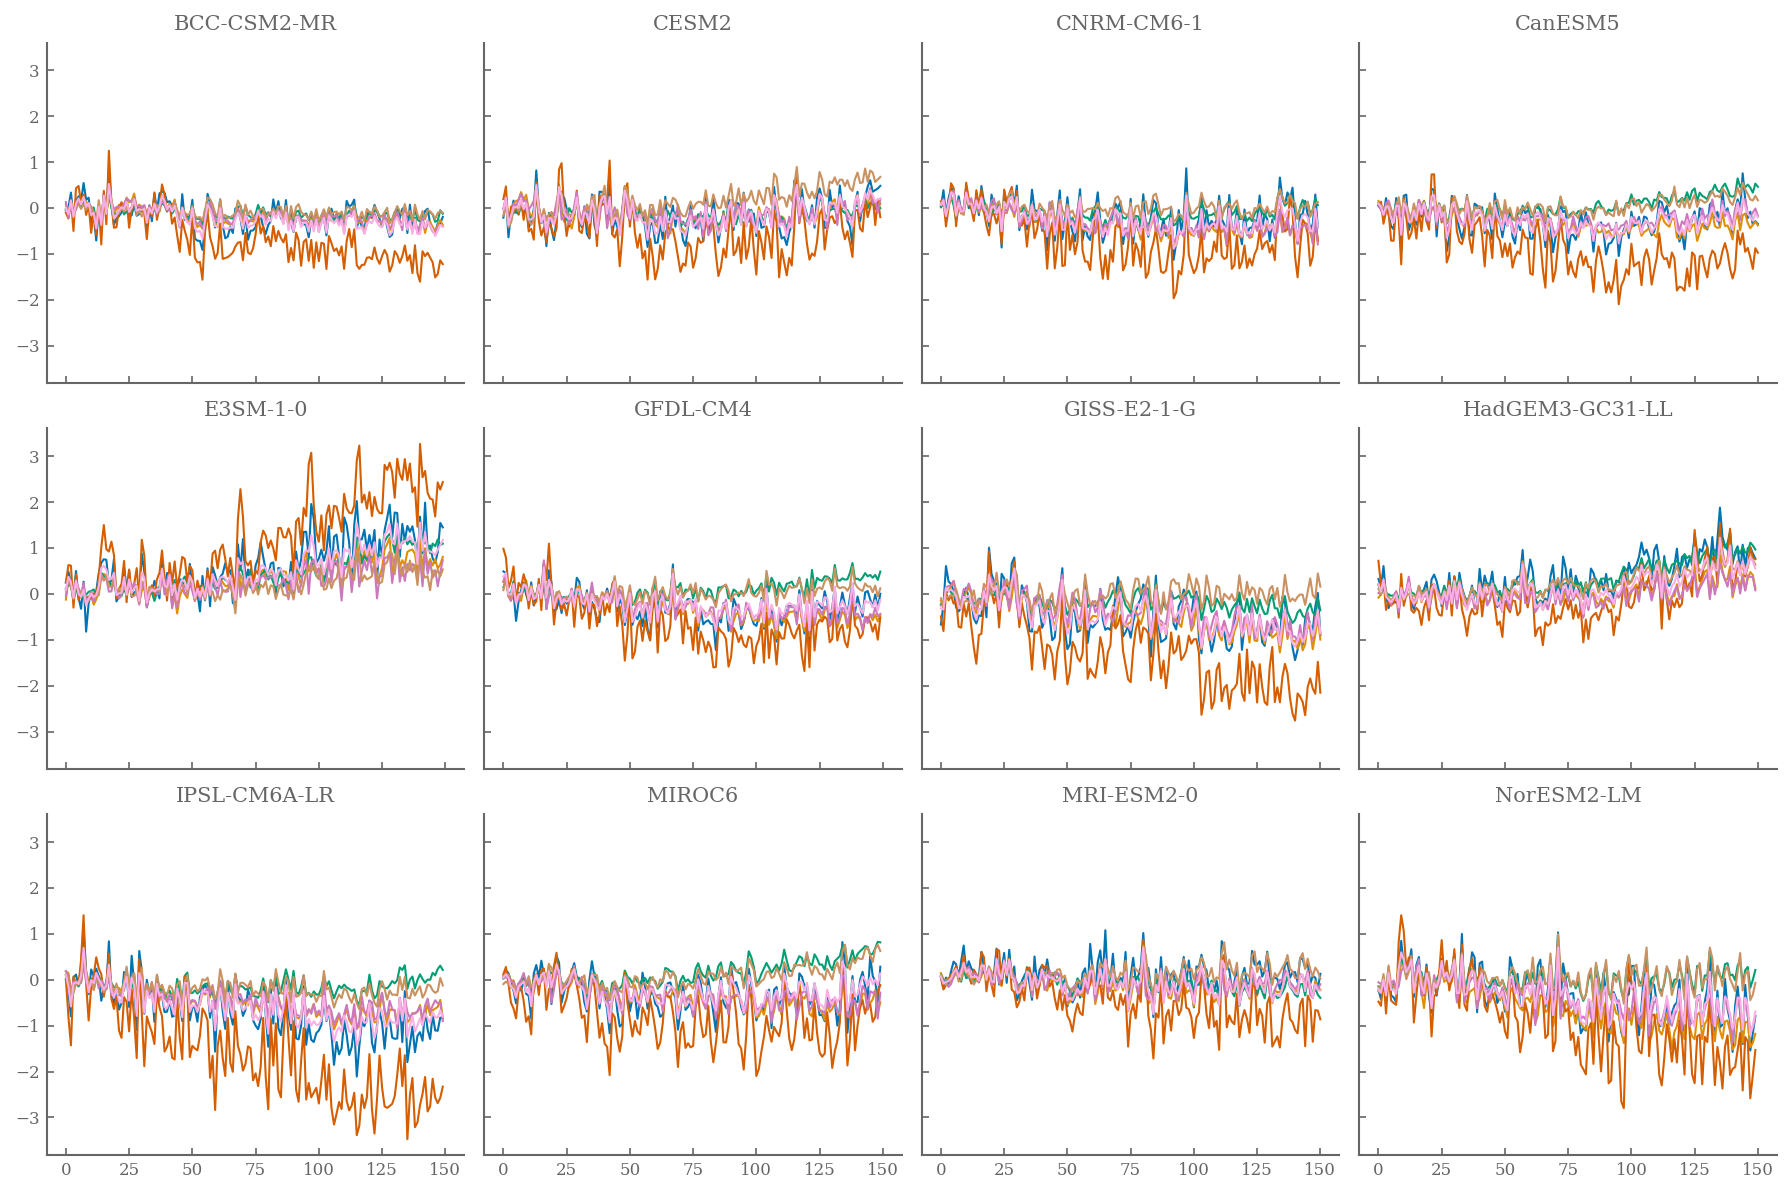

2024-08-13 17:36:06,338 - distributed.nanny - WARNING - Restarting worker
2024-08-13 17:36:06,380 - distributed.nanny - WARNING - Restarting worker
2024-08-13 17:36:06,462 - distributed.nanny - WARNING - Restarting worker
2024-08-13 17:36:06,605 - distributed.nanny - WARNING - Restarting worker
2024-08-13 17:36:06,955 - distributed.nanny - WARNING - Restarting worker
2024-08-13 17:36:08,012 - distributed.nanny - WARNING - Restarting worker


In [11]:
fig, axs = plt.subplots(3,4, figsize=(12,8), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    ds_model.dRp_gf.plot(ax=ax, add_legend=False, hue='GF_source')
    # ds_model.eei.plot(color='tab:red', lw=1, ax=ax)
    ax.set(title=ds_model.model.values,ylabel='', xlabel='')

plt.tight_layout()